# Linear Models in Machine Learning on Python - Linear Regression 4 

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from scipy.stats.mstats import normaltest
from scipy.stats import boxcox
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, 
                                   PolynomialFeatures)
from scipy.special import inv_boxcox
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from matplotlib import animation as F
from IPython.display import HTML
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
import matplotlib.animation as animation
import matplotlib.ticker as ticker
import plotly as py
import plotly.express as px
import warnings
warnings.filterwarnings('ignore', module='sklearn')
sns.set()
import plotly.io as pio
import matplotlib.image as mpimg

I want to end these lectures on linear regression with a project I have finished a while ago as one of my university projects. This dataset is a altered version of a dataset provided by Johny Hopkins University. I created this version of the actual dataset while I was preparing an assignment for the university that i study at. Now I will use this dataset to show you some animated plots as well as regression models in which we create our own transformers. I will also introduce a function called `ColumnTransformer()` which is used to split things-to-do list for numerical and categorical features.

This dataset was created on March 12, 2021. In this dataset you will find the ten countries with most active covid patients, since then the dataset isn't updated, therefore, the countries with most active cases may be changed now. The dataset contains numbers of confirmed, recovered and active cases as well as death toll per each day.

## Visualizations

Here I will use two different versions of the datasets and plot animatesplots. The first one will be a geographic plot in which I represent the active case change during the pandemic. In the second one, I will show an animated barplot which also represents the active case change. Afterwards, I will use seaborn functions that I used previously for representing covid data. 

Let's load our data first

In [3]:
data=pd.read_csv("alldatasummary.csv"); #loading our dataset

Here I wanted to do something different and use animated plots of plotly. In the plot below, I show the change in death toll geographically. Note: If you are just viewing the notebook you may not be able to see the animated graphs below. You need to run the code while you have internet connection.

In [ ]:
fig = px.choropleth(
    data[::1], 
    locations= 'Country', # We can also use lat and lon values but this one is more convenient.
    locationmode= 'country names', #Type of spatial coordinates
    color= 'sum_Active', # I will highlight sum_Active
    
    #When you draw your cursor on countries I want to show extra data about these countries. You can achieve this
    # by edding these hover properties.
    hover_name= 'Country', 
    hover_data= ['Sum_Confirmed','sum_Recovered','sum_Deaths'], 
    animation_frame= 'Date', 
    color_continuous_scale=px.colors.diverging.RdYlGn[::-1]
)    
fig.update_layout(
    title_text =   " COVID-19 Spread in the World up to 23 April 2021",
    title_x = 0.5,
    transition = {'duration': 1000000},
    geo= dict(
        showframe= False,
        showcoastlines= False,
        projection_type = 'equirectangular'
    )  
)


I also want to plot an animated barplot. To do that I will firstly load a little different version of our data and by using the function below plot the graph.

In [ ]:
data=pd.read_csv("covidextended.csv")

In [ ]:
def draw_barchart(date,case="sum_Deaths"):
    dff= (data[data['Date'].eq(date)].sort_values(by=case,ascending=False).head(10))[::-1];
    ax.clear();
    ax.barh(dff['Country'], dff[case], color=["#980505","#CD1212","#D84E4E","#CB6262","#D39B5F","#F7EC10","#D0F710","#9CF710","#B4D67F","#969C8E"][::-1]);
    dx = dff[case].max() / 100;
    for i, (value, name) in enumerate(zip(dff[case], dff['Country'])):
        ax.text(value-dx, i,     name,           size=14, weight=600, ha='right', va='bottom');
        ax.text(value-dx, i-.25, value, size=10, color='#17202A', ha='right', va='baseline');
    

    ax.text(1, 0.3, date, transform=ax.transAxes, color='#777777', size=20, ha='right', weight=500);
    ax.text(0, 1.06, 'Number of Cases', transform=ax.transAxes, size=12, color='#777777');
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'));
    ax.xaxis.set_ticks_position('top');
    ax.tick_params(axis='x', colors='#777777', labelsize=12);
    ax.set_yticks([]);
    ax.margins(0, 0.01);
    ax.grid(which='major', axis='x', linestyle='-');
    ax.set_axisbelow(True);
    ax.text(0, 1.12, 'The number of '+str(case)+' Death toll upto 2021-04-23',
            transform=ax.transAxes, size=24, weight=600, ha='left');
    plt.box(False);
    plt.tight_layout();

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8 ));
animator = animation.FuncAnimation(fig, draw_barchart, frames=data['Date'].unique());
bar_animated=HTML(animator.to_jshtml());

In [ ]:
bar_animated

I got a lot of help from this medium story while preparing these plots. I personally want to thank him and recommend you to check this story in which the author explains these steps in much more detail. [link](https://towardsdatascience.com/spread-of-covid-19-with-interactive-data-visualization-521ac471226e)

Okay now I will go on with regular plots and use the main data that I will also use for regression.

In [4]:
data=pd.read_csv("covidtenmost.csv")
data = data.rename(columns={'Sum_Confirmed': 'sum_Confirmed'})
data.head()

,Country,Date,sum_Confirmed,sum_Recovered,sum_Deaths,sum_Active,Median_CaseFatalityRatio,Median_IncidenceRate,Lat,Lon
0,United Kingdom,2020-03-23 00:00:00,6726,140,336,6250,NaN,NaN,56.4907,-4.2026
1,United Kingdom,2020-03-24 00:00:00,8164,140,423,7601,NaN,NaN,56.4907,-4.2026
2,United Kingdom,2020-03-25 00:00:00,9640,140,466,9034,NaN,NaN,56.4907,-4.2026
3,United Kingdom,2020-03-26 00:00:00,11812,150,580,11082,NaN,NaN,56.4907,-4.2026
4,United Kingdom,2020-03-27 00:00:00,14745,151,761,13833,NaN,NaN,56.4907,-4.2026


Let's use a barplot to see death toll for all the ten countries.

Text(0, 0.5, 'Country')

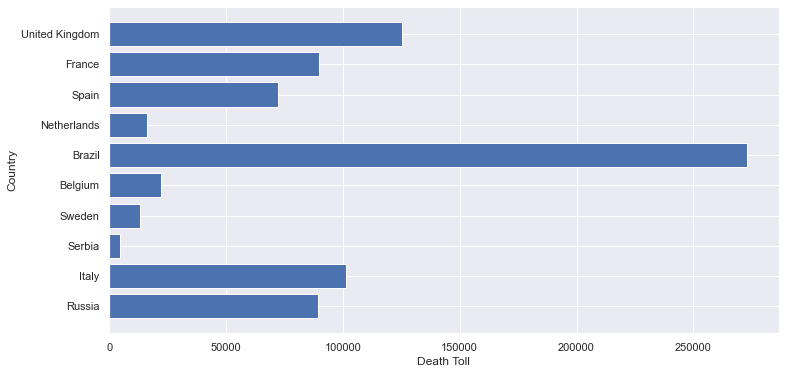

In [6]:
# This 00:00:00 is sort of irritating firstly i get rid of them. 
data['Date'] = data['Date'].str.replace(' 00:00:00','')

#data['sum_Recovered']=data['sum_Recovered'].values[data['sum_Recovered'].values <=0] = 0.0000000001 # we need this for tranformation.

country_list = data['Country'].unique().tolist()
total_list = data[data['Date'].eq('2021-03-12')]['sum_Deaths'].tolist()
plot_df = pd.DataFrame(list(zip(country_list, total_list)), 
               columns =['Country', 'sum_Death'])

plot_dff=plot_df[::-1]
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(plot_dff['Country'], plot_dff['sum_Death'])
plt.xlabel('Death Toll')
plt.ylabel('Country')

The death toll in Brazil is too high compared to others. Let's also see how the Active, Confirmed and Recovered cases change between different countries.

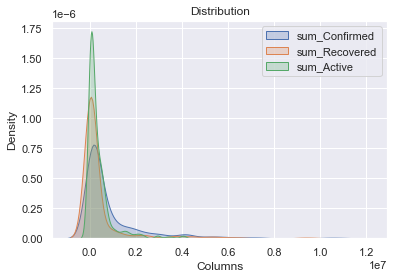

In [107]:
ax = plt.axes()
for col in data.columns:
    if "sum" in col:
        if col !="sum_Deaths":
            sns.kdeplot(data[col], shade=True,label=col)
            
            
leg = plt.legend(frameon=True)
ax.set(xlabel='Columns', 
       ylabel='Density', 
       title='Distribution');           

I wonder how to death toll changed during the pandemic. Let's create a subset of our data where we only include first day of each month and plot it to see the change in death toll.

In [108]:
data2=data.loc[data['Date'].isin(["2020-04-01 00:00:00","2020-05-01 00:00:00","2020-06-01 00:00:00","2020-07-01 00:00:00",
                            "2020-08-01 00:00:00","2020-09-01 00:00:00","2020-10-01 00:00:00","2020-11-01 00:00:00"
                           ,"2020-12-01 00:00:00","2021-01-01 00:00:00","2021-02-01 00:00:00","2021-03-01 00:00:00"])]
data2.head(5)

,Country,Date,sum_Confirmed,sum_Recovered,sum_Deaths,sum_Active,Median_CaseFatalityRatio,Median_IncidenceRate,Lat,Lon


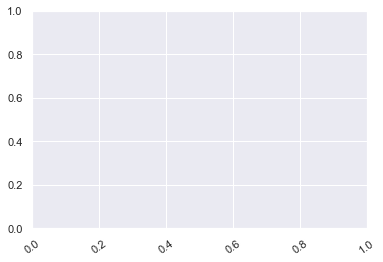

In [109]:
g=sns.histplot(data=data2, y="sum_Deaths",x="Date", hue="Country")
plt.xticks(rotation=35);

Well we can see that the death toll rises very quickly in Brazil, whereas for some countries it reaches a plato but the plot isn't that informative. Perhaps lineplot would be a better choice to visualize for that purpose.

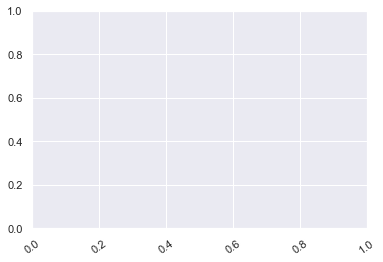

In [110]:
sns.lineplot(x="Date", y="sum_Deaths",hue="Country", marker='o',err_style='bars', data=data2)
plt.xticks(rotation=35);

Voila! Lineplot looks more clear than histplot.

Let's use boxplot on sum_Deaths

<AxesSubplot:xlabel='sum_Deaths'>

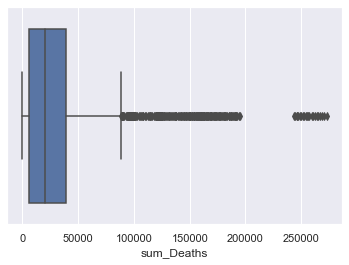

In [111]:
sns.boxplot(x=data['sum_Deaths'])

Looks like a lot of data is above interquartile range, I wonder how violinplot would look in this case.

<AxesSubplot:xlabel='sum_Deaths'>

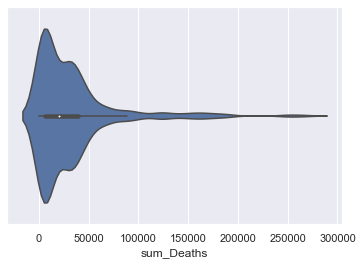

In [112]:
sns.violinplot(x=data['sum_Deaths'])

It gives a similar result as boxplot. We can also use these function for showing distribution of different categorical features. Let's say we'd like to see active cases for each country.

<AxesSubplot:xlabel='Country', ylabel='sum_Active'>

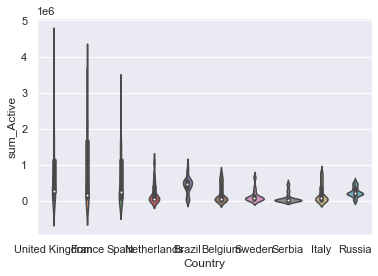

In [113]:
sns.violinplot(y=data['sum_Active'],x=data['Country'])

Let's also look at correlations. I will come back to this talk about correlations again in that notebook but for now let's only see which features is the most highly correlated with sum_Deaths.

In [114]:
corr_matrix = data.corr()
corr_matrix['sum_Deaths'].sort_values(ascending=False)

sum_Deaths                  1.000000
sum_Confirmed               0.947110
sum_Recovered               0.874510
sum_Active                  0.433687
Median_IncidenceRate        0.376991
Median_CaseFatalityRatio   -0.186322
Lat                        -0.620235
Lon                        -0.634062
Name: sum_Deaths, dtype: float64

Okay now let's visualize the most correlated and the least correlated features by using `jointplot()`

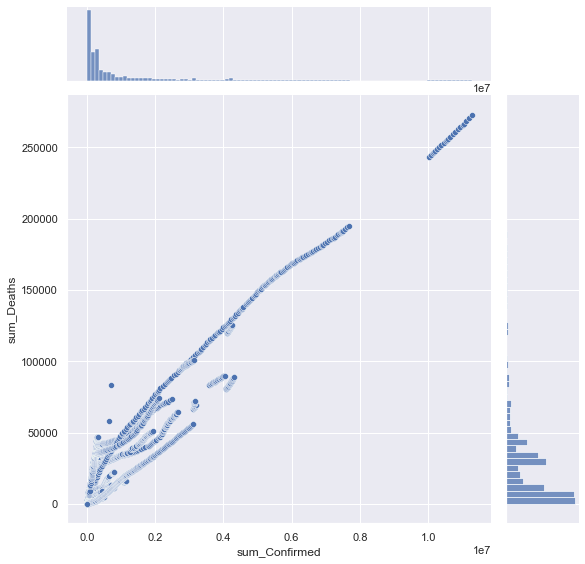

In [115]:
sns.jointplot(x=data['sum_Confirmed'], y=data['sum_Deaths'],height=8);


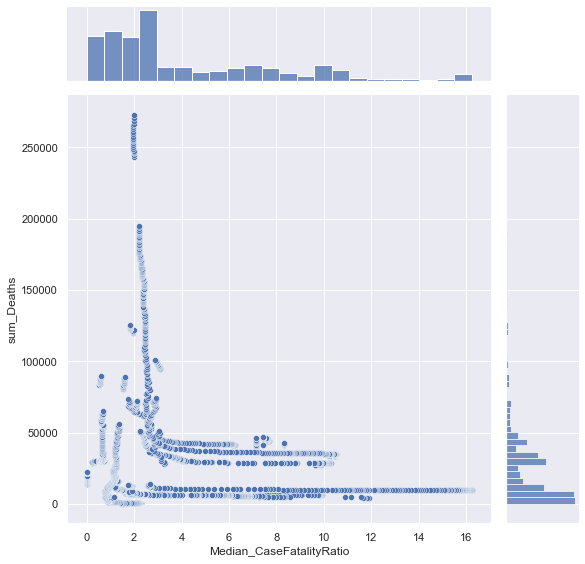

In [116]:
sns.jointplot(x=data['Median_CaseFatalityRatio'], y=data['sum_Deaths'],height=8);

Well we can see the difference clearly in the jointplot() when there is a correlation or not.

## Regression Part

### Baseline Model

I will construct two different modals. The first one will be our baseline model and the other one will be advanced where we try minimizing our error.

In [4]:
#Here i am selecting predictor features
predictors=data.iloc[:, data.columns != 'sum_Deaths']
predictors=predictors.iloc[:,2:5]
predictors.head(5)

,sum_Confirmed,sum_Recovered,sum_Active
0,6726,140,6250
1,8164,140,7601
2,9640,140,9034
3,11812,150,11082
4,14745,151,13833


In [5]:
#Selecting response variable
response=data.iloc[:,data.columns=='sum_Deaths']
response.head(5)

,sum_Deaths
0,336
1,423
2,466
3,580
4,761


In [6]:
predictors_training,predictors_test,response_training,response_test = train_test_split(predictors,response, 
test_size=0.3, random_state=42,shuffle=True) # Let's split our dataset

In [7]:
predictors_test.shape # splitting is done

(904, 3)

In [8]:
predictedvalues=LinearRegression().fit(predictors_training,response_training)

In [9]:
predictedtraining=predictedvalues.predict(predictors_training)
predictedtest=predictedvalues.predict(predictors_test)

#Calculating RMSE
training_RMSE=np.sqrt(mean_squared_error(response_training, predictedtraining))
test_RMSE=np.sqrt(mean_squared_error(response_test, predictedtest))

In [10]:
training_RMSE

4524.845466692701

In [11]:
test_RMSE

3604.9491556318144

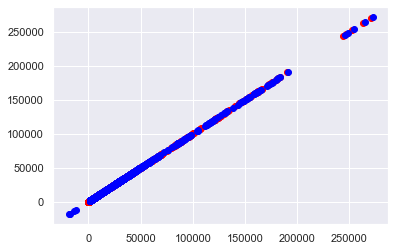

In [12]:
plt.scatter(response_test, response_test,  color='red')
plt.plot(predictedtest, predictedtest,'o', color='blue')

### Real Model

Okay In the my previous examples we show that we can create highly correlated new features. Let's create some.

Here I will impelement another dataframe in which I include population and hospital number of the ten countries. These features are important features in a situation like pandemic. I get these data with a quick search on Google so they may not be completely true.

In [7]:

population_list=["66727461","64842509","46647428","17021347","207833823","11419748","9904896","8829628","60673701",
                "145530082"]

hospital_list=["1257","3042","782","549","6738","165","100","350","1048","5300",
                ]
df_population=pd.DataFrame(population_list,columns=["Population"]) # Data frame of population
df_hospital=pd.DataFrame(hospital_list,columns=["Number of Hospitals"]) # Data frame of Hospitals
df_country=pd.DataFrame(country_list,columns=["Country"])
df_GDP=pd.concat([df_country,df_population["Population"].apply(pd.to_numeric,errors='coerce'),
                  df_hospital["Number of Hospitals"].apply(pd.to_numeric,errors='coerce')],axis = 1) # joining data frames
df_GDP

,Country,Population,Number of Hospitals
0,United Kingdom,66727461,1257
1,France,64842509,3042
2,Spain,46647428,782
3,Netherlands,17021347,549
4,Brazil,207833823,6738
5,Belgium,11419748,165
6,Sweden,9904896,100
7,Serbia,8829628,350
8,Italy,60673701,1048
9,Russia,145530082,5300


In [8]:
data_final = data.merge(df_GDP, how='left', on = 'Country')

In [9]:
data_final

,Country,Date,sum_Confirmed,sum_Recovered,sum_Deaths,sum_Active,Median_CaseFatalityRatio,Median_IncidenceRate,Lat,Lon,Population,Number of Hospitals
0,United Kingdom,2020-03-23,6726,140,336,6250,NaN,NaN,56.490700,-4.202600,66727461,1257
1,United Kingdom,2020-03-24,8164,140,423,7601,NaN,NaN,56.490700,-4.202600,66727461,1257
2,United Kingdom,2020-03-25,9640,140,466,9034,NaN,NaN,56.490700,-4.202600,66727461,1257
3,United Kingdom,2020-03-26,11812,150,580,11082,NaN,NaN,56.490700,-4.202600,66727461,1257
4,United Kingdom,2020-03-27,14745,151,761,13833,NaN,NaN,56.490700,-4.202600,66727461,1257
...,...,...,...,...,...,...,...,...,...,...,...,...
3006,Russia,2021-03-09,4284408,3878189,87985,318234,1.594498,2711.950481,52.968543,36.069248,145530082,5300
3007,Russia,2021-03-10,4293750,3888071,88315,317364,1.598784,2722.076093,52.968543,36.069248,145530082,5300
3008,Russia,2021-03-11,4302726,3901134,88773,312819,1.603109,2732.123816,52.968543,36.069248,145530082,5300
3009,Russia,2021-03-12,4311893,3914866,89224,307803,1.607376,2741.937871,52.968543,36.069248,145530082,5300


Okay now let's derive some new features

In [10]:
data_final["hospitalcapacity"]=data_final["Number of Hospitals"]/(data_final["sum_Active"]+data_final["sum_Confirmed"])
data_final["percentageinfected"]=data_final["Population"]/(data_final["sum_Confirmed"]+data_final["sum_Active"])
data_final["deathintensity"]=(data_final["sum_Active"]+data_final["sum_Confirmed"])/(data_final["sum_Deaths"])
data_final["death2recovered"]=data_final["sum_Deaths"]/data_final["sum_Recovered"]

let's look out correlations

In [11]:
data_final = data_final.corr()
data_final["sum_Deaths"].sort_values(ascending=False)

sum_Deaths                  1.000000
sum_Confirmed               0.947110
sum_Recovered               0.874510
Population                  0.616926
Number of Hospitals         0.540727
sum_Active                  0.433687
Median_IncidenceRate        0.376991
hospitalcapacity           -0.064286
percentageinfected         -0.067266
death2recovered            -0.105564
deathintensity             -0.132586
Median_CaseFatalityRatio   -0.186322
Lat                        -0.620235
Lon                        -0.634062
Name: sum_Deaths, dtype: float64

Well looks like new features aren't that correlated with death toll. However, I will use some of them in my regression model. In the next steps I don't want to deal with all these new feature adding stuffs. That's why I will create my own transformer which merges the two dataframe and generates the features. 

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    sumdeath=True
    def __init__(self,sumdeath=True): # no *args or **kargs
        self.X=0
        if(sumdeath==True):
            self.deaths=data['sum_Deaths']
    def fit(self, X, y=None): 

        return self  
    def transform(self, X):
        if('Date' in X):
            X= X.drop(['Date','Median_CaseFatalityRatio','Lat','Lon'],axis=1) # Dropping unrelevant features
            X = X.merge(df_GDP, how='left', on = 'Country')# Merging two datafranes
            X=pd.DataFrame(X,
                 columns=["Country", "sum_Confirmed","sum_Recovered","sum_Deaths","sum_Active","Median_IncidenceRate",
                "Population","Number of Hospitals"]) # Setting column names
            
        col_names = "Number of Hospitals", "sum_Active", "sum_Confirmed", "sum_Recovered","Population"
        hospital_ix, active_ix, confirmed_ix, recovered_ix, population_ix = [X.columns.get_loc(c) for c in col_names] # get the column index
        
        #creating new features
        hospitalcapacity = X.iloc[:,hospital_ix].values / (X.iloc[:,active_ix].values+X.iloc[:,confirmed_ix].values)
        percentageinfected = X.iloc[:,population_ix].values / (X.iloc[:,active_ix].values+X.iloc[:,confirmed_ix].values)
        X.iloc[:,recovered_ix]=X.iloc[:,recovered_ix].mask(X.iloc[:,recovered_ix] == 0).ffill()
        deathintensity = (X.iloc[:,active_ix].values + X.iloc[:,confirmed_ix].values) / X.iloc[:,recovered_ix].values
        death2recovered = self.deaths / X.iloc[:,recovered_ix].values
        
        #adding new features to our dataframe
        extra_attribs= np.c_[X, hospitalcapacity, percentageinfected,deathintensity,death2recovered]
        extra_attribs = pd.DataFrame(
        extra_attribs,
        columns=list(X.columns)+["Hospital_Capacity", "Infected_Population","Death_intensity","Death2recovered"],
        index=X.index)
        return extra_attribs    
        

feature_adder = CombinedAttributesAdder()
data2=feature_adder.transform(data)

Now I will introduce some new functions but before that I need to split my categorical and numeric features.

In [14]:
target=data2['sum_Deaths'] # target for regression.
data3=data2.loc[:,['Country','sum_Confirmed','sum_Recovered',
                   'sum_Active','Median_IncidenceRate','Population','Number of Hospitals']] # some part of our that

num_data=data2.loc[:,['sum_Confirmed','sum_Recovered','sum_Active',
                      'Median_IncidenceRate','Population','Number of Hospitals']] #numerical columns
cat_data=data2['Country']# categorical columns

For numerical columns I will use the pipeline below.

In [15]:
num_pipeline = Pipeline([
        ('attribs_adder', CombinedAttributesAdder(sumdeath=True)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
        ('polynomial_features',PolynomialFeatures(degree=2)),
        
    ])

covid_num_tr = num_pipeline.fit_transform(num_data)

In [16]:
covid_num_tr

array([[ 1.00000000e+00, -5.75634474e-01, -3.67306872e-01, ...,
         2.65045211e-03,  9.89839404e-03,  3.69666006e-02],
       [ 1.00000000e+00, -5.74724378e-01, -3.67306872e-01, ...,
         4.91961165e-04, -2.90253271e-03,  1.71247179e-02],
       [ 1.00000000e+00, -5.73790232e-01, -3.67306872e-01, ...,
         9.80344799e-03, -9.95188821e-03,  1.01025761e-02],
       ...,
       [ 1.00000000e+00,  2.14326115e+00,  2.52378168e+00, ...,
         1.51966113e-01,  1.66523324e-01,  1.82475006e-01],
       [ 1.00000000e+00,  2.14906285e+00,  2.53395868e+00, ...,
         1.51975020e-01,  1.66526841e-01,  1.82472019e-01],
       [ 1.00000000e+00, -5.67472091e-01, -3.66544264e-01, ...,
         7.51916391e-02,  1.14460168e-01,  1.74236526e-01]])

Now I will use `ColumnTransformer()` function to combine my pipeline with one hot encoding. By using columntransformer I will seperate which tasks to do for numerical features and which tasks to do for categorical features.

In [17]:
list(num_data)

['sum_Confirmed',
 'sum_Recovered',
 'sum_Active',
 'Median_IncidenceRate',
 'Population',
 'Number of Hospitals']

In [19]:
from sklearn.compose import ColumnTransformer
num_attribs = list(num_data)
cat_attribs = ['Country']
num_data


full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

covid_prepared = full_pipeline.fit_transform(data3)

In [23]:
data3

,Country,sum_Confirmed,sum_Recovered,sum_Active,Median_IncidenceRate,Population,Number of Hospitals
0,United Kingdom,6726,140.0,6250,NaN,66727461,1257
1,United Kingdom,8164,140.0,7601,NaN,66727461,1257
2,United Kingdom,9640,140.0,9034,NaN,66727461,1257
3,United Kingdom,11812,150.0,11082,NaN,66727461,1257
4,United Kingdom,14745,151.0,13833,NaN,66727461,1257
...,...,...,...,...,...,...,...
3006,Russia,4284408,3878189.0,318234,2711.950481,145530082,5300
3007,Russia,4293750,3888071.0,317364,2722.076093,145530082,5300
3008,Russia,4302726,3901134.0,312819,2732.123816,145530082,5300
3009,Russia,4311893,3914866.0,307803,2741.937871,145530082,5300


In [24]:
covid_prepared.shape

(3011, 76)

I do recommend checking out documentation of both `Pipeline()` and `ColumnTransformer()` because there are some other extra properties of these function which are very helpful. For instance, you can omit some columns to transform by passing  `passthrough` parameter.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(covid_prepared, target, test_size=0.3, random_state=42,shuffle=True)

In [26]:
kf = KFold(shuffle=True, random_state=42, n_splits=10)

Which parameters we can optimize by using GridSearchCV ? Let's look at which ones we can use for ridge regression.

In [27]:
Ridge().get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'random_state', 'solver', 'tol'])

Okay now I will select the parameters that I will use for optimization.

In [28]:
from sklearn.model_selection import GridSearchCV

params = {
    'alpha': np.geomspace(1e-9, 1e1, num=10),
    'fit_intercept': (True, False),
    'warm_start':(True,False)
}
params2 = {
    'alpha': np.geomspace(1e-9, 1e1, num=10),
    'solver': ('svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'),
    'fit_intercept': (True, False),
}
params3 = {
    "l1_ratio": np.linspace(0.1, 0.9, 9),
    "alpha": np.geomspace(1e-9, 1e1, num=10),
    "warm_start" :(True,False),
    "fit_intercept": (True, False),  
}


In [23]:
from sklearn.linear_model import ElasticNet
lasso = Lasso(max_iter=300)
ridge=Ridge(max_iter=300)
elasticnet=ElasticNet(max_iter=300)
models = {'Lasso': GridSearchCV(lasso, params, scoring='neg_mean_squared_error',verbose=1,return_train_score=True, cv=kf).fit(X_train, y_train),
          'Ridge': GridSearchCV(ridge, params2, scoring='neg_mean_squared_error',verbose=1, return_train_score=True,cv=kf).fit(X_train, y_train),
          'Elastic_Net':GridSearchCV(elasticnet, params3, scoring='neg_mean_squared_error',verbose=1,return_train_score=True, cv=kf).fit(X_train, y_train)}

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Fitting 10 folds for each of 120 candidates, totalling 1200 fits
Fitting 10 folds for each of 360 candidates, totalling 3600 fits


In [25]:
rmse_vals = [mean_squared_error(y_test,models['Ridge'].predict(X_test)), mean_squared_error(y_test,models['Lasso'].predict(X_test)), mean_squared_error(y_test,models['Elastic_Net'].predict(X_test))]
rsquared_vals = [r2_score(y_test,models['Ridge'].predict(X_test)),r2_score(y_test,models['Lasso'].predict(X_test)),r2_score(y_test,models['Elastic_Net'].predict(X_test))]

labels = ['Ridge', 'Lasso', 'ElasticNet']
columns=['MSE','RSquared']

df =pd.DataFrame([rmse_vals, rsquared_vals])
df=df.T
df.rename(columns={0:'RMSE',1:'RSquared'}, index={0:'Ridge',1:'Lasso',2: 'ElasticNet'}, inplace=True)
df

,RMSE,RSquared
Ridge,1.967996e-01,1.000000
Lasso,5.354136e+07,0.966474
ElasticNet,3.954766e+07,0.975236


In [143]:
mean_squared_error(y_test,models['Ridge'].predict(X_test))

0.1967996484332777

We can see the Ridge Regression performs very well on the data whereas, the two other model aren't that good. By using cv_retults_ we can get see metrics during fitting process of GridSearch. Let's look only look at how Ridge Regression improved during training since it's the best model

In [144]:
results=pd.DataFrame(models['Ridge'].cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_intercept,param_solver,params,split0_test_score,split1_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.009104,0.001446,0.000699,4.576201e-04,0.0,True,svd,"{'alpha': 1e-09, 'fit_intercept': True, 'solve...",-1.171865e-02,-2.371487e+00,...,-1.248784e-02,-1.009602e-02,-1.044741e-02,-1.074135e-02,-1.044732e-02,-1.114575e-02,-1.117292e-02,-1.035168e-02,-1.080249e-02,6.514937e-04
1,0.003299,0.000900,0.000899,2.998135e-04,0.0,True,cholesky,"{'alpha': 1e-09, 'fit_intercept': True, 'solve...",-1.171426e-02,-2.375783e+00,...,-1.248564e-02,-1.009383e-02,-1.044917e-02,-1.074532e-02,-1.044519e-02,-1.113903e-02,-1.116727e-02,-1.034492e-02,-1.080034e-02,6.510866e-04
2,0.007995,0.002190,0.000600,4.901592e-04,0.0,True,lsqr,"{'alpha': 1e-09, 'fit_intercept': True, 'solve...",-1.617938e+07,-2.262057e+08,...,-1.252007e+07,-1.706199e+07,-1.666346e+07,-1.690183e+07,-1.699652e+07,-1.680210e+07,-1.655278e+07,-1.464794e+07,-1.619539e+07,1.397927e+06
3,0.004496,0.000499,0.000500,4.999174e-04,0.0,True,sparse_cg,"{'alpha': 1e-09, 'fit_intercept': True, 'solve...",-1.324288e+07,-4.597661e+08,...,-1.431182e+07,-1.414289e+07,-1.474774e+07,-1.472401e+07,-1.491335e+07,-1.460729e+07,-1.342736e+07,-1.464794e+07,-1.449213e+07,4.137098e+05
4,0.467701,0.051488,0.000795,3.974583e-04,0.0,True,sag,"{'alpha': 1e-09, 'fit_intercept': True, 'solve...",-3.106489e+08,-2.870777e+08,...,-2.677935e+08,-3.061095e+08,-3.066523e+08,-3.045673e+08,-3.078161e+08,-3.051473e+08,-3.052000e+08,-3.047119e+08,-3.021458e+08,1.150148e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.003199,0.000748,0.000799,3.996151e-04,10.0,False,cholesky,"{'alpha': 10.0, 'fit_intercept': False, 'solve...",-1.202624e+07,-2.158955e+08,...,-1.272426e+07,-1.266290e+07,-1.318325e+07,-1.324132e+07,-1.334675e+07,-1.321328e+07,-1.199233e+07,-1.322470e+07,-1.299084e+07,3.954751e+05
116,0.007396,0.001684,0.000899,2.998198e-04,10.0,False,lsqr,"{'alpha': 10.0, 'fit_intercept': False, 'solve...",-1.797016e+07,-1.642939e+08,...,-1.514721e+07,-1.769150e+07,-1.824391e+07,-1.891375e+07,-1.710790e+07,-1.857915e+07,-1.707328e+07,-1.682480e+07,-1.770158e+07,1.125886e+06
117,0.006396,0.000663,0.001000,8.120244e-07,10.0,False,sparse_cg,"{'alpha': 10.0, 'fit_intercept': False, 'solve...",-1.641148e+07,-1.987166e+08,...,-1.627960e+07,-1.642940e+07,-1.691892e+07,-1.712403e+07,-1.574047e+07,-1.681310e+07,-1.423580e+07,-1.682477e+07,-1.643463e+07,8.353619e+05
118,0.463731,0.037738,0.000300,4.581515e-04,10.0,False,sag,"{'alpha': 10.0, 'fit_intercept': False, 'solve...",-4.316379e+08,-4.522050e+08,...,-3.930972e+08,-4.354818e+08,-4.377888e+08,-4.316788e+08,-4.363040e+08,-4.355223e+08,-4.345233e+08,-4.330327e+08,-4.308348e+08,1.268632e+07


We can find configuration of best model by using best_estimator_ attribute

In [145]:
models['Ridge'].best_estimator_

Ridge(alpha=1e-09, fit_intercept=False, max_iter=300, solver='cholesky')

By using the data in cv_results_ we I want to show the progress of the model.

Text(0, 0.5, 'MSE')

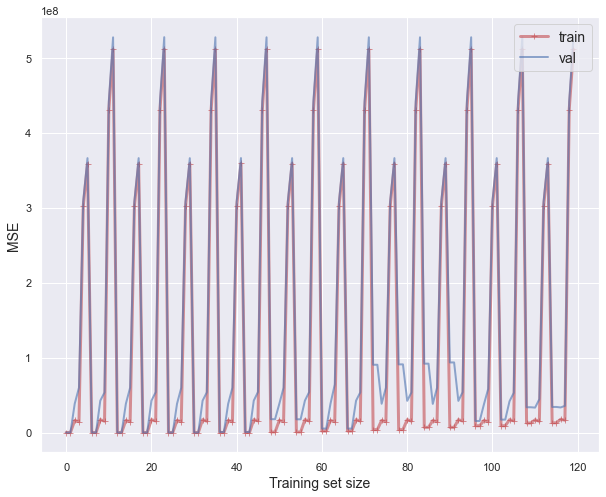

In [146]:
sns.set()
plt.figure(figsize=(10,8))
plt.plot(abs(models['Ridge'].cv_results_['mean_train_score']), "r-+", linewidth=3, label="train",alpha=0.6)
plt.plot(abs(models['Ridge'].cv_results_['mean_test_score']), "b-", linewidth=2, label="val",alpha=0.6)
plt.legend(loc="upper right", fontsize=14)   # not shown in the book
plt.xlabel("Training set size", fontsize=14) # not shown
plt.ylabel("MSE", fontsize=14)

Let's also use kdeplot() for the same porpuse to see whether it can represent the data better.

Text(0.5, 0, 'Candidates')

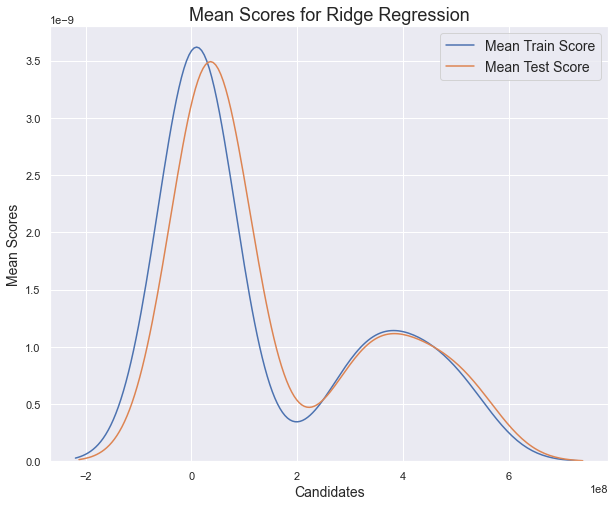

In [147]:
plt.figure(figsize=(10,8))
ax=sns.kdeplot(abs(models['Ridge'].cv_results_['mean_train_score'])).set_title("Mean Scores for Ridge Regression",fontsize=18)
sns.kdeplot(abs(models['Ridge'].cv_results_['mean_test_score']))
plt.legend(['Mean Train Score', 'Mean Test Score'],fontsize=14)
plt.ylabel("Mean Scores",fontsize=14)
plt.xlabel("Candidates",fontsize=14)

We can see how the error changed during training.

In [148]:
def plot_learning_curves():
    X_train, X_test, y_train, y_test = train_test_split(covid_prepared, target, test_size=0.3, random_state=42,shuffle=True)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        ridge=Ridge(alpha=1e-09, fit_intercept=False, max_iter=100).fit(X_train[:m], y_train[:m])
        y_train_predict = ridge.predict(X_train[:m])
        y_val_predict = ridge.predict(X_test)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_test, y_val_predict))

    plt.plot(train_errors, "r-+", linewidth=1, label="train")
    plt.plot(val_errors, "b-", linewidth=1, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14) 

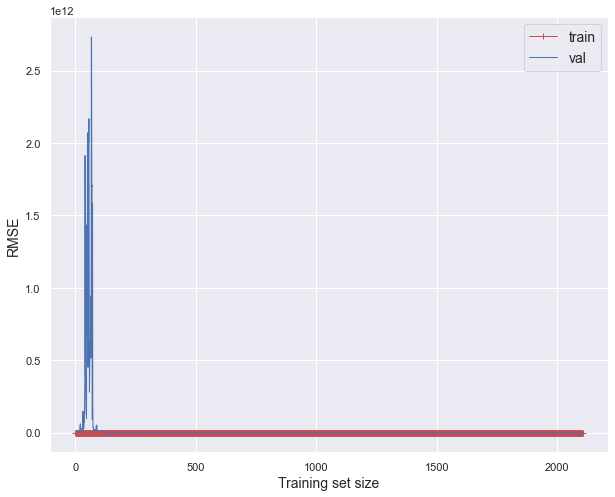

In [149]:
plt.figure(figsize=(10,8))
plot_learning_curves()
plt.show() 


Well It looks like we didn't improve training error much, however, validation error reduced a lot and this is actually what matters.

## Early Stopping

There is a concept that I didn't mention before and I think it is now the right time to mention about it. Early Stopping is actually a regularization technique in which we monitore the performance of our model and stop training when the generalization error increases. This technique is used more often with neural networks but we can also use it here. I will firstly implement it manually.

In [150]:
num_data=SimpleImputer(strategy="median").fit_transform(num_data)

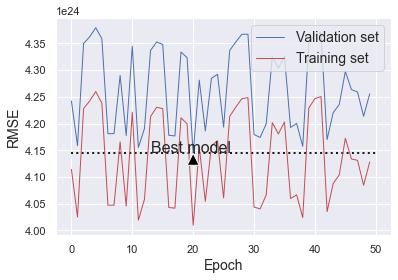

In [151]:
#num_data.drop('Median_IncidenceRate',axis=1,inplace=True) # I don't want to use this columns so I just drop it.
X_train, X_test, y_train, y_test = train_test_split(num_data, target, test_size=0.3, random_state=42,shuffle=True)

#I will use SGDRegressor instead of classical Linear Regression.
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty="l2", learning_rate="constant", eta0=0.0005, random_state=42)

num_iteration = 50
train_errors, val_errors = [], []
for epoch in range(num_iteration):
    sgd_reg.fit(X_train, y_train)
    train_predict = sgd_reg.predict(X_train)
    val_predict = sgd_reg.predict(X_test)
    train_errors.append(mean_squared_error(y_train, train_predict))
    val_errors.append(mean_squared_error(y_test, val_predict))

best_num_iteration = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_num_iteration])

plt.annotate('Best model ',
             xy=(best_num_iteration, best_val_rmse),
             xytext=(best_num_iteration, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )


plt.plot([0, num_iteration], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=1, label="Validation set")
plt.plot(np.sqrt(train_errors), "r-", linewidth=1, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

We get the best validation score in the 20th iteration (If we iterate for 50 times). Now I will use this technique in a easier way, the reason that I used `SGDRegressor()` here was that we can actually implement Early Stopping as a parameter of `SGDRegressor()` I will also use `GridSearchCV()`.

Let's look at which parameters we can optimize.

In [152]:
sgd_reg.get_params().keys()

dict_keys(['alpha', 'average', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

Now let's apply GridSearch on that. The thing I would like to point out is I set `validation_fraction=0.1` which means I will use %10 of the data for validation. Moreover, I set `early_stopping=True` and `n_iter_no_change=15`, that means if there isn't change in validation error for 15 times of iteration the algorithm will be stopped. 

In [154]:
X_train, X_test, y_train, y_test = train_test_split(covid_prepared, target, test_size=0.3, random_state=42,shuffle=True)

params_sgd = {
    'alpha': np.geomspace(1e-9, 1e1, num=10),
    'eta0':  np.geomspace(1e-9, 1e1, num=10),
    'learning_rate':('invscaling', 'adaptive'),
    'fit_intercept': (True, False),
    'shuffle':(True, False),
}

sgd_reg = SGDRegressor(max_iter=500, tol=-np.infty, warm_start=True,validation_fraction=0.1, penalty='l2', random_state=42, early_stopping=True, n_iter_no_change=15)

grid_search=GridSearchCV(sgd_reg, params_sgd, scoring='neg_mean_squared_error',verbose=1,return_train_score=True, cv=kf)

grid_search.fit(X_train, y_train)

predicted=grid_search.predict(X_test)
mean_squared_error(y_test, predicted)

Fitting 10 folds for each of 800 candidates, totalling 8000 fits


475328592.62060684

The result is extremely bad.

Now finally, we are done with linear regression. I will be showing other regression algorithms with regression trees and perhaps SVM Regression but we have some time for that. In the next notebooks, we will be talking about logistic regression. I'm planning to release 3 notebooks about logistic regression but there may be one more.